# Visualizations - combo case optimization

In [1]:
import policy_epidemic_model_code

import importlib

import numpy as np
import importlib
import matplotlib.pyplot as plt


import pandas as pd
import visualization

import kMedoids_clustering
from kMedoids_clustering import GetSwitch, GetCluster, CalcPearson, GetInitialMedoids, kMedoids
from math import floor
from run_definitions import get_runs_definitions
from matplotlib.pyplot import cm


In [33]:
# reimports to avoid restarting kernel after every update
importlib.reload(policy_epidemic_model_code)
from policy_epidemic_model_code import *

importlib.reload(visualization)
from visualization import *
from run_tools import (create_simu_run, create_sub_policy, create_policy, construct_policy, create_epidemic_model, Policy_template, Policy, 
                       collect_results, cluster_run, extract_selected, simulate_solutions, remove_dominated)

In [3]:
risk_limit = 0.10

In [4]:
all_runs = get_runs_definitions()

In [57]:
# list all runs that are to be analysed
run_keys = ['combo_base_case', 
            'combo_base_case_tc_1000000',
            'combo_base_case_tc_2500000',
            'combo_base_case_tc_5000000',
            'combo_base_case_tc_25000000',
            'combo_base_case_tc_50000000',
            'combo_base_case_tc_100000000',
            'romer_tc_50000000_sens_spec_085',
            'romer_tc_25000000_sens_spec_085',
            'romer_tc_5000000_sens_spec_085',
            'romer_tc_2500000_sens_spec_085',
            'romer_sens_spec_085',
            'combo_base_case_test_and_trace_tc50000000_ss085',
            'combo_base_case_test_and_trace_tc25000000_ss085',
            'combo_base_case_test_and_trace_tc5000000_ss085',
            'romer',
            'romer_tc_25000000',
            'romer_tc_5000000',
            'romer_tc_50000000',
            'romer_sens_spec_085',
            'romer_sens_spec_095',
            'base_case_lockdown_opt',
            'test_and_trace_lockdown_opt_eta100',
            'combo_base_case_tc_50000000_sens_spec_085',
            #'base_case_no_control'
                
]
runs = { run_key: all_runs[run_key] for run_key in run_keys }

no_ctrl = no_ctrl = ['base_case_no_control', 'base_case_no_control_R0_4.0', 'base_case_no_control_high_gamma', 'base_case_no_control_BMH_rpl', 'test_and_trace_no_control_eta50', 'test_and_trace_no_control_eta100', 'test_and_trace_no_control_R0_4.0_eta50', 'test_and_trace_no_control_R0_4.0_eta100']

In [58]:
romer_runs = ['romer_tc_50000000_sens_spec_085',
            'romer_tc_25000000_sens_spec_085',
            'romer_tc_5000000_sens_spec_085',
            'romer_tc_2500000_sens_spec_085',
            'romer_sens_spec_085', 'romer_tc_25000000',
            'romer_tc_5000000',
            'romer_tc_50000000',
            'romer_sens_spec_085',
            'romer_sens_spec_095','romer']

In [59]:
full_results = {}

for run in runs:
    full_results[run] = pd.read_csv('active_results/' + run + '_full_results_f-cand.csv', delimiter=',')    
    
    # rescaling
    wrong_scale = 2 / (0.5 + 2)
    right_scale = 2 / (0.5/2 + 2)
    full_results[run]["Economic impact"] = full_results[run]["Economic impact"]*(right_scale / wrong_scale)

    

/Users/ljneuvon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



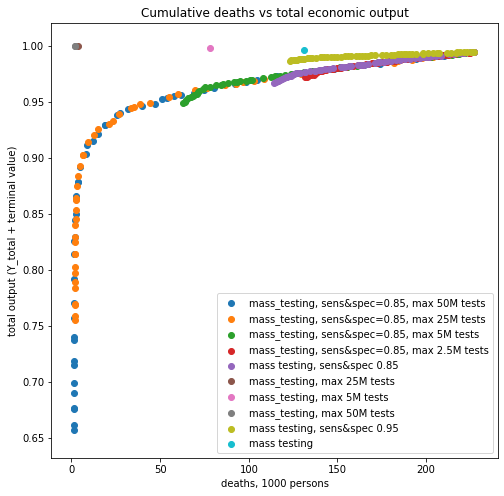

In [60]:
plot_runs = romer_runs
plot_run_dict = { run: runs[run] for run in plot_runs }
obj_dict = { run: full_results[run][['Deaths', 'Economic impact']] for run in plot_runs }
fig = pareto_plot(plot_run_dict, obj_dict)

#fig.savefig("figures/mass_testing_cases.png", dpi=150)
fig.show()

# Pruning cases

In [61]:
# These options are the same for all pruning cases.
# NOTE: keep combo cases first - this helps with clustering if clustering mixed approaches
policy_options = ['combo_base_case', 'combo_base_case_tc_50000000_sens_spec_085', 'romer',
            'base_case_lockdown_opt',
             'test_and_trace_lockdown_opt_eta100',
            'romer_tc_50000000_sens_spec_085',
                 # 'romer_tc_50000000'
            ]

/Users/ljneuvon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



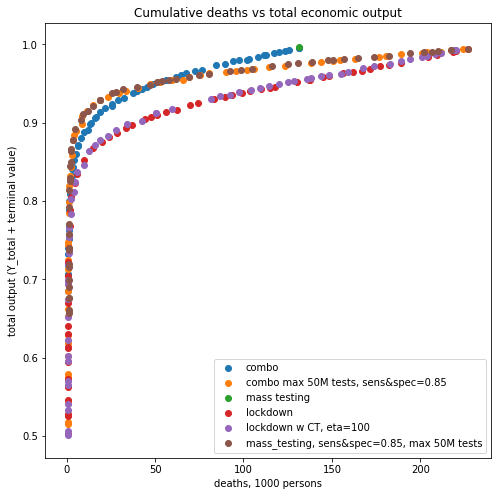

In [62]:
plot_runs = policy_options
plot_run_dict = { run: runs[run] for run in plot_runs }
obj_dict = { run: full_results[run][['Deaths', 'Economic impact']] for run in plot_runs }
fig = pareto_plot(plot_run_dict, obj_dict)

fig.savefig("figures/combo_cases.png", dpi=150)
fig.show()

In [63]:

all_results = pd.DataFrame()
results_dict = {}

wrong_scale = 2 / (0.5 + 2)
right_scale = 2 / (0.5/2 + 2)

for run_i, run in enumerate(policy_options):

    results_dict[run] = pd.read_csv('active_results/risk_analysis/' + run + '_full_results_f-cand_risk.csv', delimiter=',', index_col=0)
    # rescaling

    results_dict[run]["Economic impact"] = results_dict[run]["Economic impact"]*(right_scale / wrong_scale)
    
    results_dict[run]['run'] = run # adds run name to into a new column (for each row from that run)
    results_dict[run]['original index'] = results_dict[run].index
    all_results = all_results.append(results_dict[run])

    
print(all_results.index)


Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
            ...
            50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
           dtype='int64', length=301)


## Risk - combine - cluster

In [84]:
# remove too risky (coombination done in previous phase)

low_risk = all_results[all_results['max ICUOL P'] < risk_limit]
low_risk_by_run = {}
high_risk_by_run = {}
for run in plot_runs:
    low_risk_by_run[run] = all_results[(all_results['max ICUOL P'] < risk_limit) & (all_results['run']==run)]
    high_risk_by_run[run] = all_results[(all_results['max ICUOL P'] >= risk_limit) & (all_results['run']==run)]

/Users/ljneuvon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



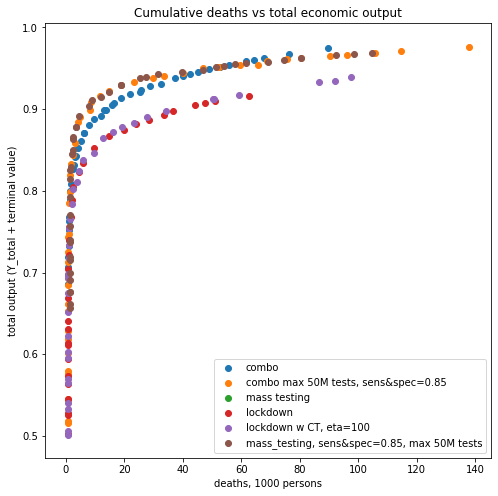

In [65]:
plot_runs = policy_options
plot_run_dict = { run: runs[run] for run in plot_runs }
obj_dict = { run: low_risk_by_run[run][['Deaths', 'Economic impact']] for run in plot_runs }
fig = pareto_plot(plot_run_dict, obj_dict)

fig.savefig("figures/combo_cases.png", dpi=150)
fig.show()

In [66]:
# Remove dominated solutions from combined front
non_dom_low_risk = remove_dominated(low_risk, ['Deaths', 'Economic impact'], [-1, -1])
len(non_dom_low_risk.index)

66

In [67]:
# cluster - mixed approaches, whole front as one set oof solutions
import kMedoids_clustering
import sys

importlib.reload(sys.modules['kMedoids_clustering'])
from kMedoids_clustering import GetSwitch, GetCluster, CalcPearson, GetInitialMedoids, kMedoids

non_dom_low_risk = non_dom_low_risk.drop(columns=['cluster'], errors='ignore') # remove old clusterings
non_dom_low_risk_pol = non_dom_low_risk.drop(columns=['Deaths', 'Economic impact', 'pareto cluster', 'cluster', 'run', 'original index', 'ICUOL (CVaR 10%)', 'max ICUOL P'], errors='ignore')
n_clusters=10
c_res = cluster_run(non_dom_low_risk_pol, n_clusters, grouping=non_dom_low_risk['run'].tolist())

clusters = c_res[0]
medoids = c_res[1]
loc = len(non_dom_low_risk.columns)
non_dom_low_risk.insert(loc, 'cluster', clusters)
#non_dom_low_risk.to_csv('active_results/Pareto_front_clustered' + '.csv')
#pareto_medoid_res = extract_selected([run], full_results[run], run_medoids, save_csv=True, csv_identifier='medoid') # saves medoid solutions to run specific csv's
#run_medoid_results[run] = run_medoid_res
medoids_ind = non_dom_low_risk.iloc[medoids,:].index
medoids_df = non_dom_low_risk.loc[medoids_ind,:]

combo_base_case
combo_base_case_tc_50000000_sens_spec_085
combo_base_case
combo_base_case_tc_50000000_sens_spec_085
combo_base_case
combo_base_case_tc_50000000_sens_spec_085
combo_base_case
combo_base_case_tc_50000000_sens_spec_085
combo_base_case
combo_base_case_tc_50000000_sens_spec_085
combo_base_case
combo_base_case_tc_50000000_sens_spec_085
combo_base_case
combo_base_case_tc_50000000_sens_spec_085
combo_base_case
combo_base_case_tc_50000000_sens_spec_085
combo_base_case
combo_base_case_tc_50000000_sens_spec_085
combo_base_case
combo_base_case_tc_50000000_sens_spec_085
combo_base_case
combo_base_case_tc_50000000_sens_spec_085
combo_base_case
combo_base_case_tc_50000000_sens_spec_085
combo_base_case
combo_base_case_tc_50000000_sens_spec_085
combo_base_case
combo_base_case_tc_50000000_sens_spec_085
combo_base_case
combo_base_case_tc_50000000_sens_spec_085
combo_base_case
combo_base_case_tc_50000000_sens_spec_085
combo_base_case
combo_base_case_tc_50000000_sens_spec_085
combo_base_cas

combo_base_case
romer_tc_50000000_sens_spec_085
combo_base_case
romer_tc_50000000_sens_spec_085
combo_base_case
romer_tc_50000000_sens_spec_085
combo_base_case
romer_tc_50000000_sens_spec_085
combo_base_case
romer_tc_50000000_sens_spec_085
combo_base_case
romer_tc_50000000_sens_spec_085
combo_base_case
romer_tc_50000000_sens_spec_085
combo_base_case
romer_tc_50000000_sens_spec_085
combo_base_case
romer_tc_50000000_sens_spec_085
combo_base_case
combo_base_case_tc_50000000_sens_spec_085
combo_base_case
combo_base_case_tc_50000000_sens_spec_085
combo_base_case
combo_base_case_tc_50000000_sens_spec_085
combo_base_case
combo_base_case_tc_50000000_sens_spec_085
combo_base_case
combo_base_case_tc_50000000_sens_spec_085
combo_base_case
combo_base_case_tc_50000000_sens_spec_085
combo_base_case
combo_base_case_tc_50000000_sens_spec_085
combo_base_case
combo_base_case_tc_50000000_sens_spec_085
combo_base_case
combo_base_case_tc_50000000_sens_spec_085
combo_base_case
combo_base_case_tc_50000000_se

combo_base_case_tc_50000000_sens_spec_085
base_case_lockdown_opt
combo_base_case_tc_50000000_sens_spec_085
base_case_lockdown_opt
combo_base_case_tc_50000000_sens_spec_085
base_case_lockdown_opt
combo_base_case_tc_50000000_sens_spec_085
test_and_trace_lockdown_opt_eta100
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_se

base_case_lockdown_opt
combo_base_case_tc_50000000_sens_spec_085
base_case_lockdown_opt
combo_base_case_tc_50000000_sens_spec_085
base_case_lockdown_opt
combo_base_case_tc_50000000_sens_spec_085
test_and_trace_lockdown_opt_eta100
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_se

combo_base_case_tc_50000000_sens_spec_085
combo_base_case
combo_base_case_tc_50000000_sens_spec_085
combo_base_case
combo_base_case_tc_50000000_sens_spec_085
combo_base_case
combo_base_case_tc_50000000_sens_spec_085
combo_base_case
combo_base_case_tc_50000000_sens_spec_085
combo_base_case
combo_base_case_tc_50000000_sens_spec_085
combo_base_case
combo_base_case_tc_50000000_sens_spec_085
combo_base_case
combo_base_case_tc_50000000_sens_spec_085
combo_base_case
combo_base_case_tc_50000000_sens_spec_085
combo_base_case
combo_base_case_tc_50000000_sens_spec_085
base_case_lockdown_opt
combo_base_case_tc_50000000_sens_spec_085
base_case_lockdown_opt
combo_base_case_tc_50000000_sens_spec_085
base_case_lockdown_opt
combo_base_case_tc_50000000_sens_spec_085
test_and_trace_lockdown_opt_eta100
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_085
romer_tc_5000000

combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_

combo_base_case
romer_tc_50000000_sens_spec_085
combo_base_case
romer_tc_50000000_sens_spec_085
combo_base_case
romer_tc_50000000_sens_spec_085
combo_base_case
romer_tc_50000000_sens_spec_085
combo_base_case
romer_tc_50000000_sens_spec_085
combo_base_case
romer_tc_50000000_sens_spec_085
combo_base_case
romer_tc_50000000_sens_spec_085
combo_base_case
romer_tc_50000000_sens_spec_085
combo_base_case
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_085
romer_tc_50000000_sens_spec_085
combo_base_case_tc_50000000_sens_spec_085
romer_tc

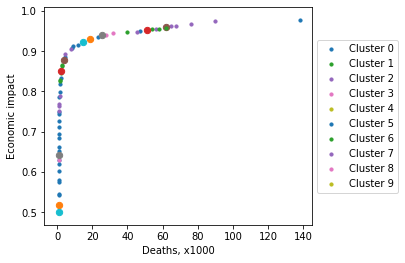

In [68]:
run_df = non_dom_low_risk

medoid_obj = medoids_df[['Deaths', 'Economic impact']]
#medoid_solutions = medoid_df.drop(columns=['Deaths', 'Economic impact', 'cluster', 'run', 'pareto_cluster', 'original index'], errors='ignore')
n_clusters = len(medoids_df.index)

fig = plt.figure()
ax = plt.subplot(111)

color=iter(cm.tab10(np.linspace(0,1,10)))
for i in range(0,n_clusters):
    ax.scatter(run_df[run_df['cluster']==i].Deaths, 
                -run_df[run_df['cluster']==i]["Economic impact"], 
                label="Cluster "+str(i),
               alpha=1.0, 
               s=10)
    ax.scatter(medoids_df.iloc[i,:].Deaths, 
                -medoids_df.iloc[i,:]["Economic impact"],
               s=40)
    next(color)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc = 'center left', bbox_to_anchor=(1,0.5))
plt.xlabel('Deaths, x1000')
plt.ylabel('Economic impact')
plt.show()

/Users/ljneuvon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



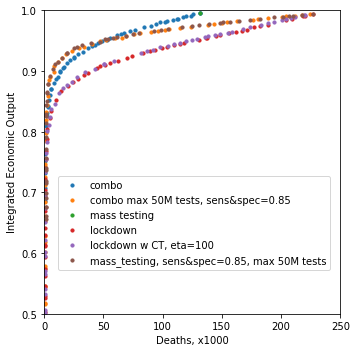

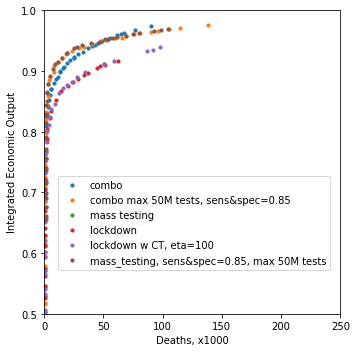

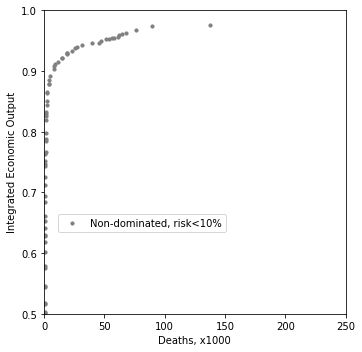

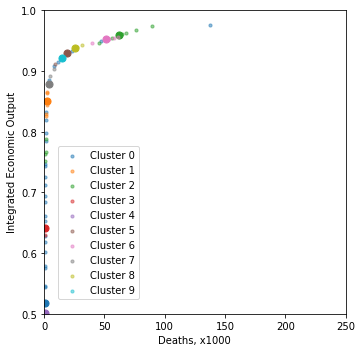

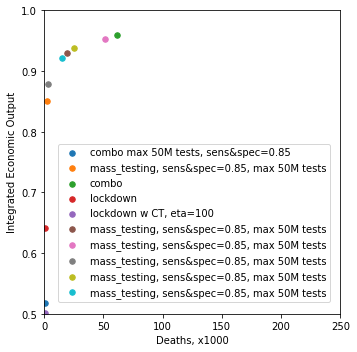

In [19]:
# same but separately

plot_runs = policy_options

fig = plt.figure(figsize=(5,5))

plot_run_dict = { run: runs[run] for run in plot_runs }
obj_dict = { run: full_results[run][['Deaths', 'Economic impact']] for run in plot_runs }

ax1 = plt.subplot()
for run in plot_runs:
    ax1.scatter(obj_dict[run].Deaths, -obj_dict[run]['Economic impact'], label=run_labels[run], s=10)

box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax1.legend(loc = 'center left', bbox_to_anchor=(0.03,0.3))

plt.xlabel('Deaths, x1000')
plt.ylabel('Integrated Economic Output')
plt.ylim([0.5, 1.0])
plt.xlim([0, 250])
fig.tight_layout()
fig.savefig("figures/pruning_1.png", dpi=150)

fig = plt.figure(figsize=(5,5))

ax2 = plt.subplot()
for run in plot_runs:
    ax2.scatter(low_risk_by_run[run].Deaths, -low_risk_by_run[run]['Economic impact'], label=run_labels[run], s=10)

box = ax2.get_position()
ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax2.legend(loc = 'center left', bbox_to_anchor=(0.03,0.3))

plt.xlabel('Deaths, x1000')
plt.ylabel('Integrated Economic Output')
plt.ylim([0.5, 1.0])
plt.xlim([0, 250])
fig.tight_layout()
fig.savefig("figures/pruning_2.png", dpi=150)

fig = plt.figure(figsize=(5,5))

ax3 = plt.subplot()
ax3.scatter(non_dom_low_risk.Deaths, -non_dom_low_risk['Economic impact'], c='gray', label='Non-dominated, risk<10%', s=10
           )
plt.xlabel('Deaths, x1000')
plt.ylabel('Integrated Economic Output')
plt.ylim([0.5, 1.0])
plt.xlim([0, 250])

box = ax.get_position()
ax3.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax3.legend(loc = 'center left', bbox_to_anchor=(0.03,0.3))
fig.tight_layout()
fig.savefig("figures/pruning_3.png", dpi=150)

fig = plt.figure(figsize=(5,5))

ax4 = plt.subplot()
run_df = non_dom_low_risk
color=iter(cm.tab10(np.linspace(0,1,10)))
for i in range(0,n_clusters):
    c=next(color)
    ax4.scatter(run_df[run_df['cluster']==i].Deaths, 
                -run_df[run_df['cluster']==i]["Economic impact"], 
                label="Cluster "+str(i),
               alpha=0.5, 
               s=10, color=c)
    ax4.scatter(medoids_df.iloc[i,:].Deaths, 
                -medoids_df.iloc[i,:]["Economic impact"],
               s=50, color=c)
plt.ylim([0.5, 1.0]) 
plt.xlim([0, 250])
box = ax4.get_position()
ax4.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax4.legend(loc = 'center left', bbox_to_anchor=(0.03, 0.3))


plt.xlabel('Deaths, x1000')
plt.ylabel('Integrated Economic Output')

fig.tight_layout()
fig.savefig("figures/pruning_4.png", dpi=150)

fig = plt.figure(figsize=(5,5))

ax5 = plt.subplot()
color=iter(cm.tab10(np.linspace(0,1,10)))
#ax.scatter(run_df.Deaths, -run_df['Economic impact'], s=10, c='gray')
medoids_sorted_by_cluster = medoids_df.sort_values('cluster')
for i in medoids_sorted_by_cluster.index:
   
    c=next(color)
    ax5.scatter(medoids_df.loc[i, 'Deaths'], -medoids_df.loc[i, 'Economic impact'], s=30, color=c, label=run_labels[medoids_df.loc[i, 'run']])
    #ax5.annotate(medoids_df['max ICUOL P'][i], (medoids_df.loc[i, 'Deaths']+1, -medoids_df.loc[i, 'Economic impact']-0.015))


plt.xlabel('Deaths, x1000')
plt.ylabel('Integrated Economic Output')
plt.ylim([0.5, 1.0])
plt.xlim([0, 250])

box = ax5.get_position()
ax5.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax5.legend(loc = 'center left', bbox_to_anchor=(0.03,0.3))

fig.tight_layout()
fig.show()
fig.savefig("figures/pruning_5.png", dpi=150)

<function matplotlib.pyplot.show(*args, **kw)>

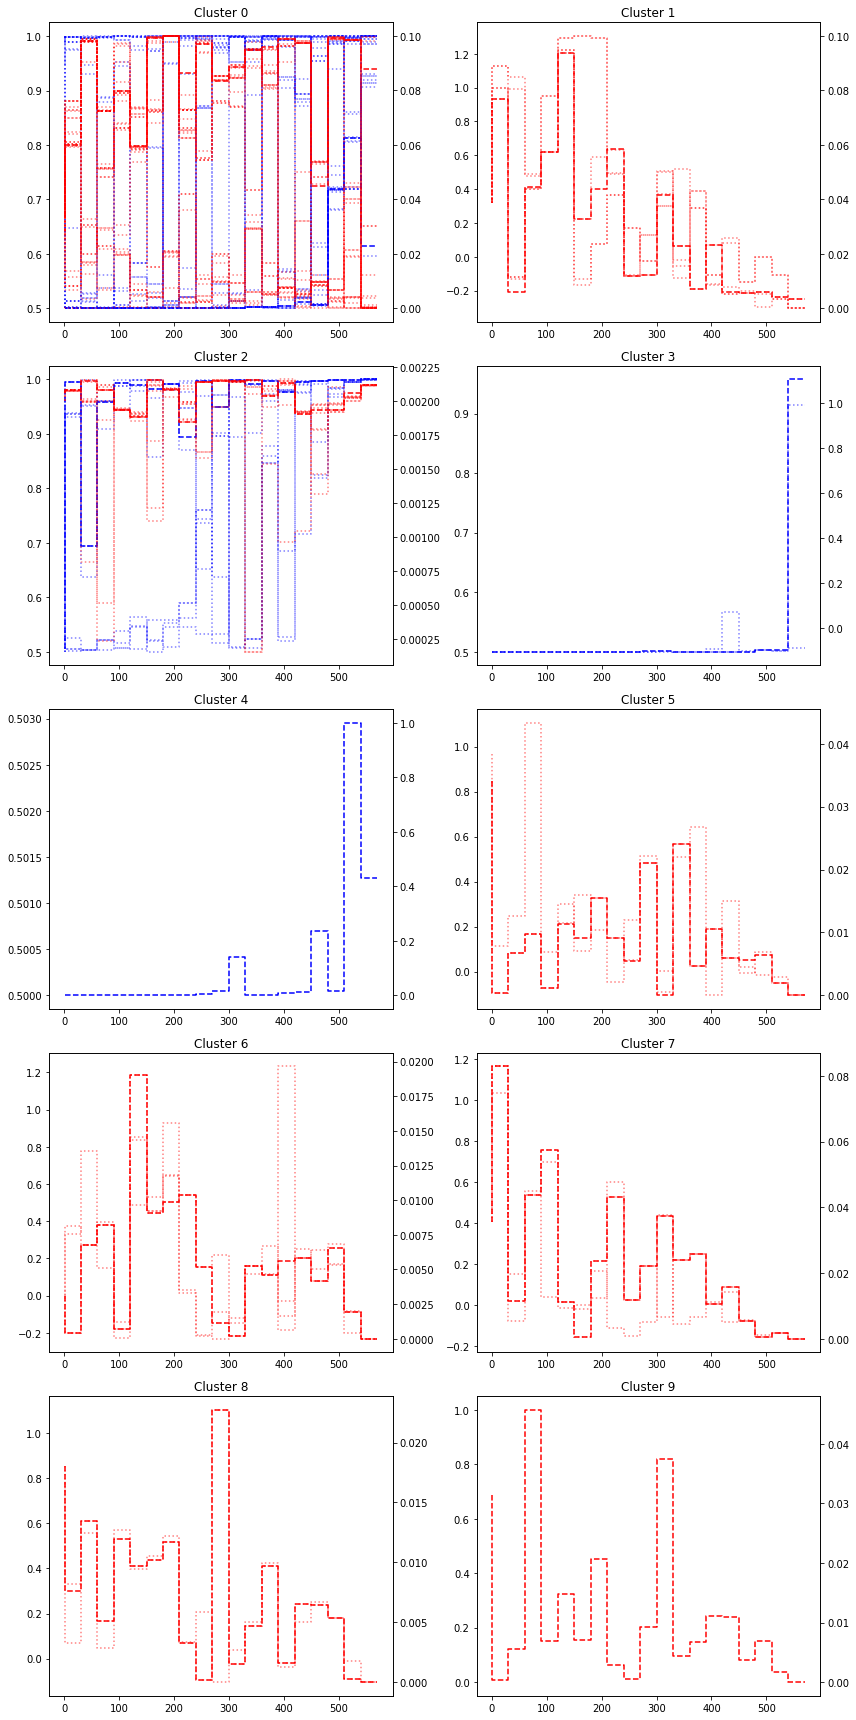

In [21]:

k = n_clusters

fig, axes = plt.subplots(nrows=(int((k+1)/2)), ncols=2, figsize=(12,24) )
all_policies = non_dom_low_risk
for i in range(0,k):
    cluster_policies = all_policies[all_policies['cluster']==i].drop(columns=['Deaths', 'Economic impact', 'cluster', 'run', 'original index', 'pareto cluster', 'ICUOL (CVaR 10%)', 'max ICUOL P'], errors='ignore')
    axes[floor(i/2), i%2].set_title("Cluster " + str(i) )
    cluster_policies.columns = [eval(c) for c in cluster_policies.columns]
    policy_types = np.unique([c[0] for c in cluster_policies.columns])

    for type in policy_types:
        col_list = [c for c in cluster_policies.columns if c[0]==type]
        t = [col[1] for col in col_list]
        if type=='ld': 
            color='blue'
        else: 
            color='red'
            secax = axes[floor(i/2), i%2].twinx()
                
        for pol_i, pol in enumerate(cluster_policies.index):
            if type=='ld':
                
                if pol in medoids_ind:
                    #print("ld med")
                    axes[floor(i/2), i%2].step(t, cluster_policies.loc[pol,col_list], '--', c=color)
                else:
                    #print("ld non med")
                    axes[floor(i/2), i%2].step(t, cluster_policies.loc[pol,col_list], ':', c=color, alpha=0.5)
                #axes[floor(i/2), i%2].legend(fontsize='x-small')
            elif type=='test':
                if pol in medoids_ind:
                    #print("test med")
                    secax.step(t, cluster_policies.loc[pol,col_list], '--', c=color)
                else:
                    #print("test non med")
                    secax.step(t, cluster_policies.loc[pol,col_list], ':', c=color, alpha=0.5)
plt.tight_layout()
plt.show

0
1
2
3
4
5
6
7
8


IndexError: index 2 is out of bounds for axis 0 with size 2

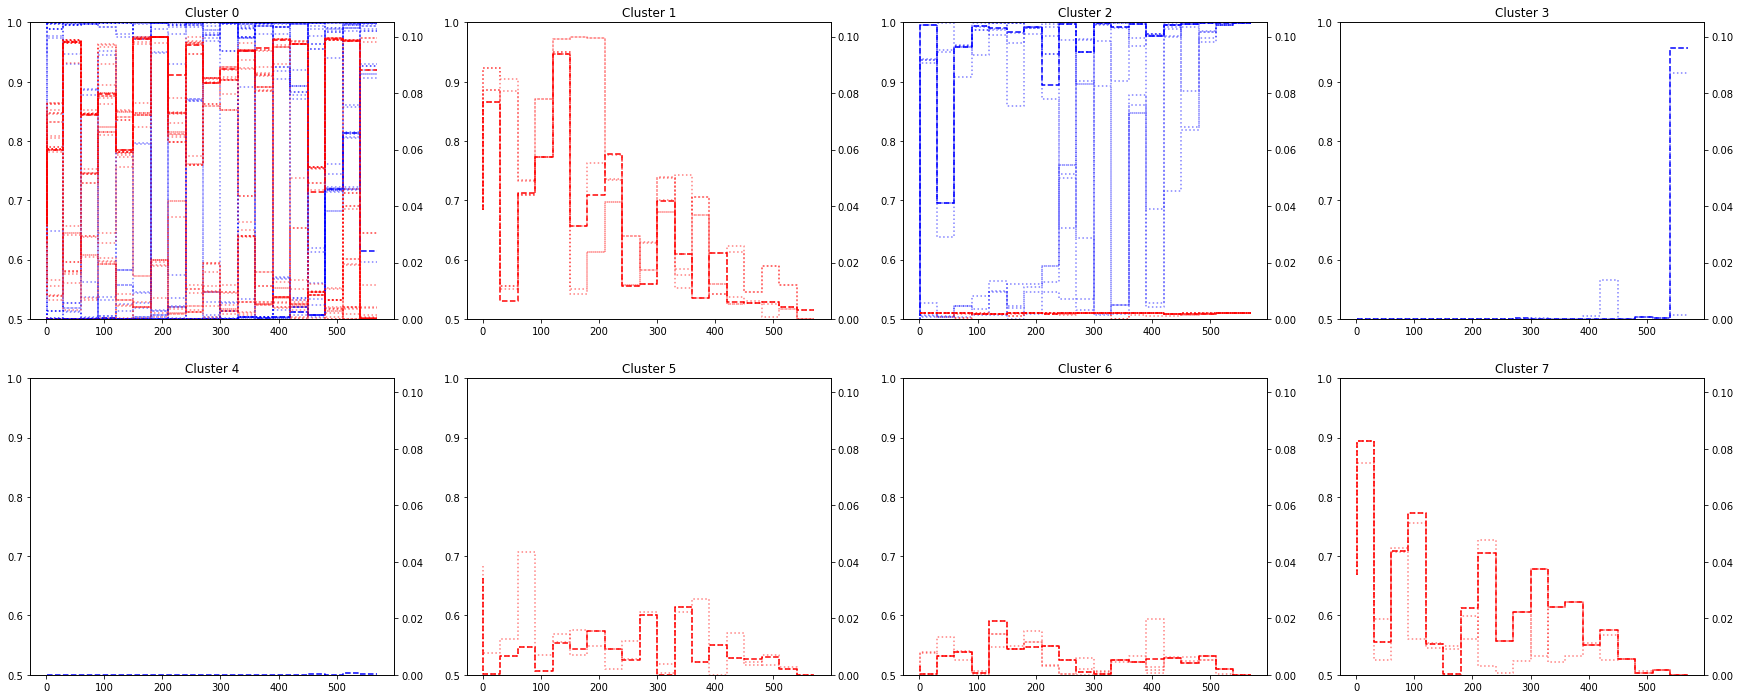

In [44]:

k = n_clusters
ncols=4
fig, axes = plt.subplots(nrows=(int((k+1)/ncols)), ncols=ncols, figsize=(30,12) )
all_policies = non_dom_low_risk

for i in range(0,k):
    # here 'cluster' is just a policy
    print(i)
    #run = all_policies.loc[index, 'run']
    cluster_policies = all_policies[all_policies['cluster']==i].drop(columns=['Deaths', 'Economic impact', 'cluster', 'run', 'original index', 'pareto cluster', 'ICUOL (CVaR 10%)', 'max ICUOL P'], errors='ignore')
    axes[floor(i/ncols), i%ncols].set_title("Cluster " + str(i))
    axes[floor(i/ncols), i%ncols].set_ylim([0.5, 1.0])
    cluster_policies.columns = [eval(c) for c in cluster_policies.columns]
    policy_types = np.unique([c[0] for c in cluster_policies.columns])

    for type in policy_types:
        col_list = [c for c in cluster_policies.columns if c[0]==type]
        t = [col[1] for col in col_list]
        if type=='ld': 
            color='blue'
        else: 
            color='red'
            secax = axes[floor(i/ncols), i%ncols].twinx()
            secax.set_ylim([0.0, 0.105])
                
        for pol_i, pol in enumerate(cluster_policies.index): 
            if type=='ld':
                
                if pol in medoids_ind:
                    #print("ld med")
                    axes[floor(i/ncols), i%ncols].step(t, cluster_policies.loc[pol,col_list], '--', c=color)
                else:
                    #print("ld non med")
                    axes[floor(i/ncols), i%ncols].step(t, cluster_policies.loc[pol,col_list], ':', c=color, alpha=0.5)
                #axes[floor(i/2), i%2].legend(fontsize='x-small')
            elif type=='test':
                if pol in medoids_ind:
                    #print("test med")
                    secax.step(t, cluster_policies.loc[pol,col_list], '--', c=color)
                else:
                    #print("test non med")
                    secax.step(t, cluster_policies.loc[pol,col_list], ':', c=color, alpha=0.5)

fig.savefig("figures/clusters_after_risk.png", dpi=150)
plt.tight_layout()
plt.show

/Users/ljneuvon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



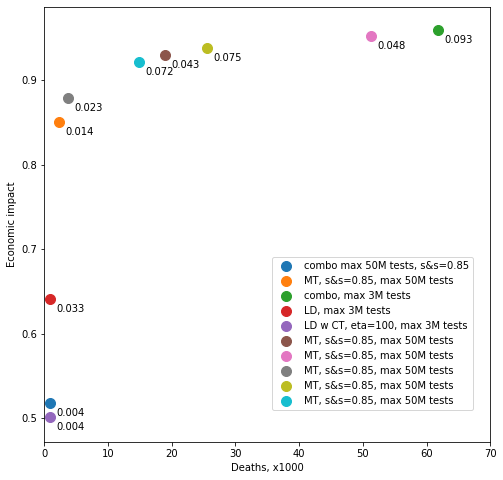

In [42]:
plot_runs = policy_options
color=iter(cm.tab10(np.linspace(0,1,10)))
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111)
#ax.scatter(run_df.Deaths, -run_df['Economic impact'], s=10, c='gray')
for i in medoids_sorted_by_cluster.index:
    c=next(color)
    ax.scatter(medoids_df.loc[i, 'Deaths'], -medoids_df.loc[i, 'Economic impact'], s=100, color=c, 
               #label=run_labels[medoids_df.loc[i, 'run']]+' | index:'+str(i)
               label=short_run_labels[medoids_df.loc[i, 'run']]
              )
#fig.savefig("figures/combo_cases.png", dpi=150)
plt.xlabel('Deaths, x1000')
plt.xlim([0, 70])

plt.ylabel('Economic impact')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc = 'center left', bbox_to_anchor=(0.5, 0.25))
#ax.legend()

for i, index in enumerate(medoids_df.index):
    ax.annotate(round(medoids_df['max ICUOL P'][index], 3), (medoids_df.loc[index, 'Deaths']+1, -medoids_df.loc[index, 'Economic impact']-0.015))

fig.show()

KeyError: 77

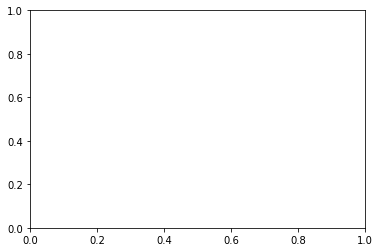

In [91]:

n_sol = len(medoids_df.index)
color=iter(cm.tab10(np.linspace(0,1,n_sol)))
sample_obj = {}
medoid_obj = {}

fig = plt.figure()
ax = plt.subplot(111)

medoid_risk_runs = np.unique(medoids_df.run)

for index in medoids_df.index:
    c=next(color)
    run = all_results.loc[index, 'run']
    run_index_orig = all_results[all_results.run==run].loc[index, 'original index']
    medoid = all_results[all_results.run==run][all_results['original index']==run_index_orig]
    sample_df = pd.read_csv('active_results/risk_analysis/' + run + '__' + str(run_index_orig) + 'full_results_f-cand_.csv', delimiter=',')
    sample_obj = sample_df[['Deaths', 'Output']]
    ax.scatter(sample_obj.Deaths, -sample_obj.Output, color=c, alpha=0.1, s=10)
    ax.scatter(medoid.loc[index, 'Deaths'], -medoid.loc[index, "Economic impact"], color=c, edgecolor='w',
                label="P(ICU > C): " + str(round(medoid.loc[index, 'max ICUOL P'] ,3)) + " " + run_labels[run])
    #print(medoid.loc[index, 'Deaths'])
#plt.xlim(-2000, 40000)
#plt.ylim(0.7, 1.1)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc = 'center left', bbox_to_anchor=(1,0.5))

0
1
2
3
4
5
6
7
8


IndexError: index 2 is out of bounds for axis 0 with size 2

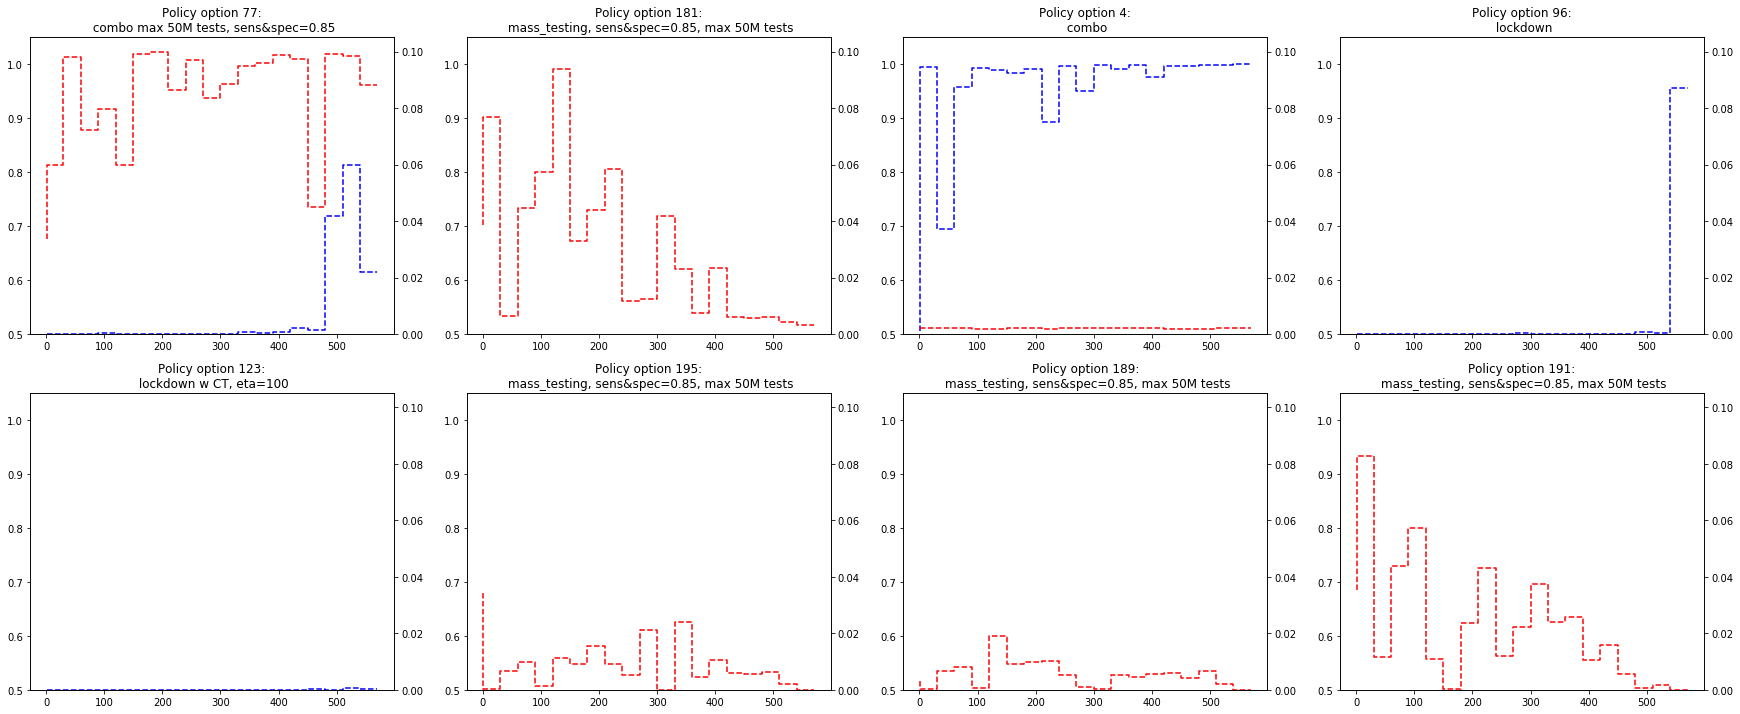

In [25]:

k = len(medoids_df.index)
ncols=4
fig, axes = plt.subplots(nrows=(int((k+1)/ncols)), ncols=ncols, figsize=(30,12) )
all_policies = medoids_df
for i, index in enumerate(all_policies.index):
    # here 'cluster' is just a policy
    print(i)
    run = all_policies.loc[index, 'run']
    cluster_policies = all_policies.drop(columns=['Deaths', 'Economic impact', 'cluster', 'run', 'original index', 'pareto cluster', 'ICUOL (CVaR 10%)', 'max ICUOL P'], errors='ignore')
    axes[floor(i/ncols), i%ncols].set_title("Policy option " + str(index) + ":\n " + run_labels[run] )
    axes[floor(i/ncols), i%ncols].set_ylim([0.5, 1.05])
    cluster_policies.columns = [eval(c) for c in cluster_policies.columns]
    policy_types = np.unique([c[0] for c in cluster_policies.columns])

    for type in policy_types:
        col_list = [c for c in cluster_policies.columns if c[0]==type]
        t = [col[1] for col in col_list]
        if type=='ld': 
            color='blue'
        else: 
            color='red'
            secax = axes[floor(i/ncols), i%ncols].twinx()
            secax.set_ylim([0.0, 0.105])
                
        for pol_i, pol in enumerate([cluster_policies.index[i]]): # <<- ugly hack from a cluster plotting script
            if type=='ld':
                
                if pol in medoids_ind:
                    #print("ld med")
                    axes[floor(i/ncols), i%ncols].step(t, cluster_policies.loc[pol,col_list], '--', c=color)
                else:
                    #print("ld non med")
                    axes[floor(i/ncols), i%ncols].step(t, cluster_policies.loc[pol,col_list], ':', c=color, alpha=0.5)
                #axes[floor(i/2), i%2].legend(fontsize='x-small')
            elif type=='test':
                if pol in medoids_ind:
                    #print("test med")
                    secax.step(t, cluster_policies.loc[pol,col_list], '--', c=color)
                else:
                    #print("test non med")
                    secax.step(t, cluster_policies.loc[pol,col_list], ':', c=color, alpha=0.5)

fig.savefig("figures/clusters_after_risk.png", dpi=150)
#plt.tight_layout()
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

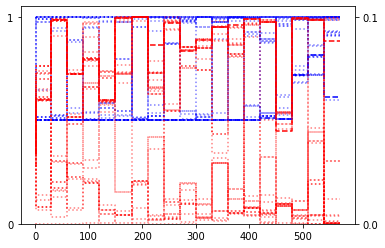

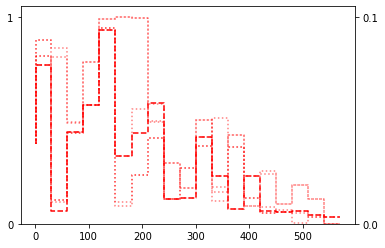

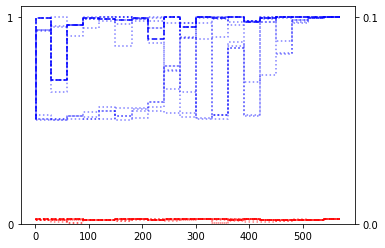

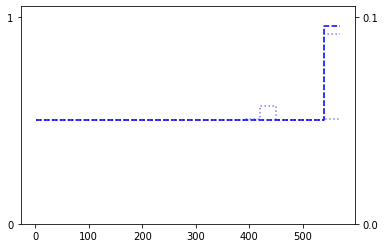

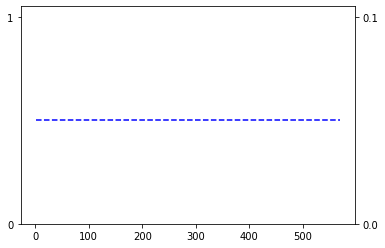

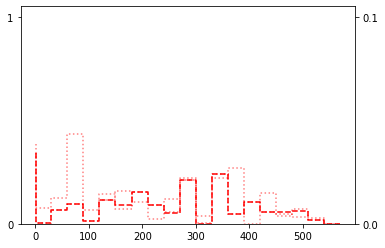

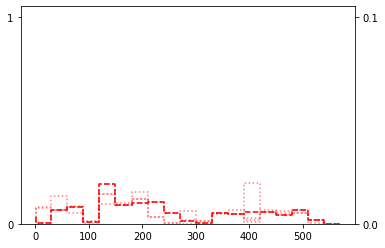

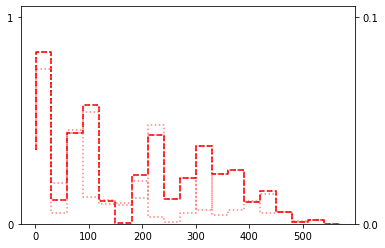

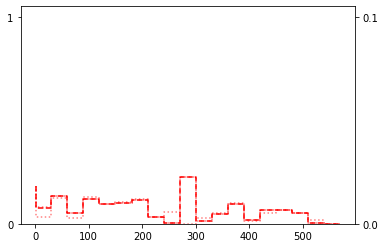

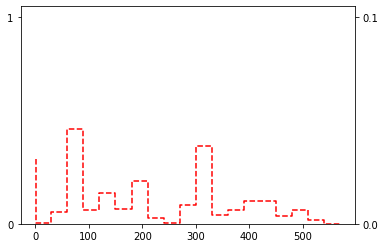

In [98]:
# Save policy plots into separate files
k = len(medoids_df.index)

all_policies = non_dom_low_risk
for i in range(0,k):
    fig = plt.figure()
    ax = plt.subplot(111)
    cluster_policies = all_policies[all_policies['cluster']==i].drop(columns=['Deaths', 'Economic impact', 'cluster', 'run', 'original index', 'pareto cluster', 'ICUOL (CVaR 10%)', 'max ICUOL P'], errors='ignore')
    #ax.set_title(f"{short_run_labels[run]}", fontsize=24)
    #ax.set_title(f"Policy option {str(index)}:\n{short_run_labels[run]} \nDeaths: {deaths} | Econ. impact: {output}", fontsize=28)
    ax.set_ylim([0.45, 1.05])
    cluster_policies.columns = [eval(c) for c in cluster_policies.columns]
    policy_types = np.unique([c[0] for c in cluster_policies.columns])

    for type in policy_types:
        col_list = [c for c in cluster_policies.columns if c[0]==type]
        t = [col[1] for col in col_list]
        if type=='ld': 
            color='blue'
        else: 
            color='red'
            secax = ax.twinx()
            secax.set_ylim([0.0, 0.105])
                
        for pol_i, pol in enumerate(cluster_policies.index): 
            if type=='ld':
                
                if pol in medoids_ind:
                    #print("ld med")
                    ax.step(t, cluster_policies.loc[pol,col_list], '--', c=color)
                else:
                    #print("ld non med")
                    ax.step(t, cluster_policies.loc[pol,col_list], ':', c=color, alpha=0.5)
                #axes[floor(i/2), i%2].legend(fontsize='x-small')
            elif type=='test':
                if pol in medoids_ind:
                    #print("test med")
                    secax.step(t, cluster_policies.loc[pol,col_list], '--', c=color)
                else:
                    #print("test non med")
                    secax.step(t, cluster_policies.loc[pol,col_list], ':', c=color, alpha=0.5)
    
    # Style: sparkline
    # remove all the axes
    #for k,v in ax.spines.items():
    #    v.set_visible(False)
    #ax.set_xticks([0.0, 1.0])
    ax.set_yticks([0.0, 1.0])
        
    for k,v in secax.spines.items():
        v.set_visible(False)
    #secax.set_xticks([])
    secax.set_yticks([0.0, 0.1])

    fig.savefig(f"figures/clusters_after_risk_{i}.png", dpi=150)
#plt.tight_layout()
plt.show

0
Deaths: 0.92, Output: 0.52
1
Deaths: 2.39, Output: 0.85
2
Deaths: 61.78, Output: 0.96
3
Deaths: 0.92, Output: 0.64
4
Deaths: 0.92, Output: 0.5
5
Deaths: 18.95, Output: 0.93
6
Deaths: 51.29, Output: 0.95
7
Deaths: 3.72, Output: 0.88
8
Deaths: 25.51, Output: 0.94
9
Deaths: 14.87, Output: 0.92


<function matplotlib.pyplot.show(*args, **kw)>

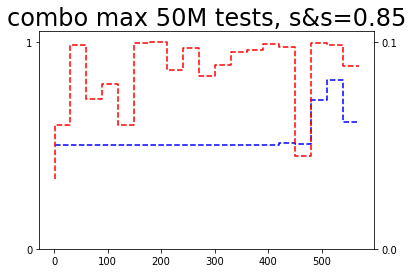

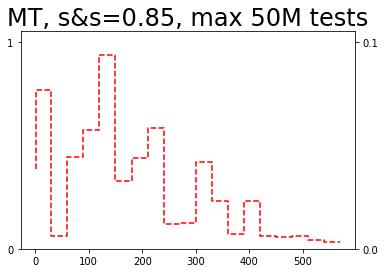

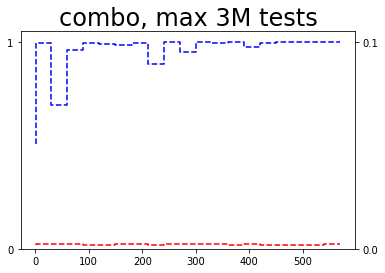

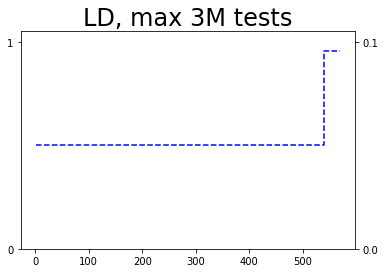

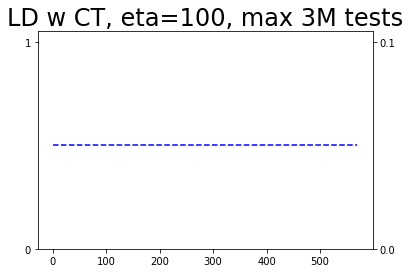

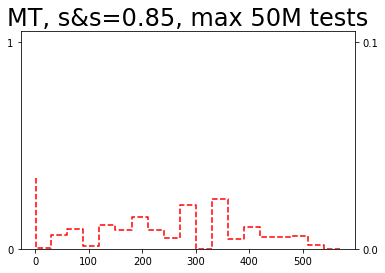

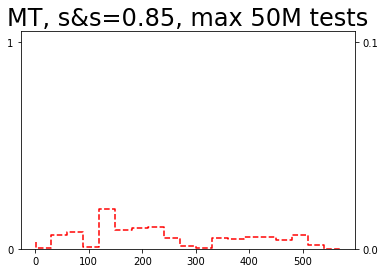

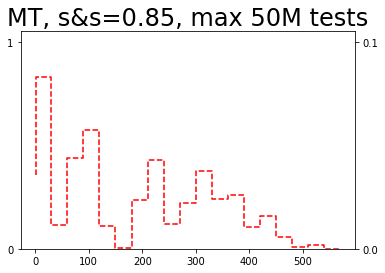

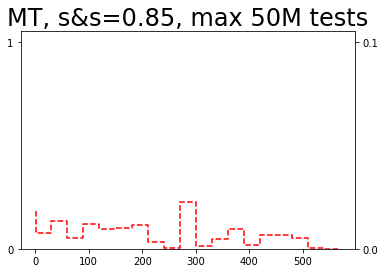

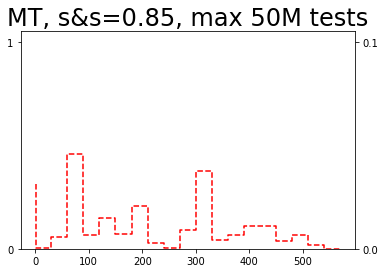

In [35]:
# Save policy plots into separate files
k = len(medoids_df.index)

all_policies = medoids_df
for i, index in enumerate(all_policies.index):
    fig = plt.figure()
    ax = plt.subplot(111)
    # here 'cluster' is just a policy
    print(i)
    run = all_policies.loc[index, 'run']
    deaths = round(medoids_df.loc[index, 'Deaths'], 2)
    output = round(-medoids_df.loc[index, 'Economic impact'], 2)
    print(f"Deaths: {deaths}, Output: {output}")
    cluster_policies = all_policies.drop(columns=['Deaths', 'Economic impact', 'cluster', 'run', 'original index', 'pareto cluster', 'ICUOL (CVaR 10%)', 'max ICUOL P'], errors='ignore')
    ax.set_title(f"{short_run_labels[run]}", fontsize=24)
    #ax.set_title(f"Policy option {str(index)}:\n{short_run_labels[run]} \nDeaths: {deaths} | Econ. impact: {output}", fontsize=28)
    ax.set_ylim([0.45, 1.05])
    cluster_policies.columns = [eval(c) for c in cluster_policies.columns]
    policy_types = np.unique([c[0] for c in cluster_policies.columns])

    for type in policy_types:
        col_list = [c for c in cluster_policies.columns if c[0]==type]
        t = [col[1] for col in col_list]
        if type=='ld': 
            color='blue'
        else: 
            color='red'
            secax = ax.twinx()
            secax.set_ylim([0.0, 0.105])
                
        for pol_i, pol in enumerate([cluster_policies.index[i]]): # <<- ugly hack from a cluster plotting script
            if type=='ld':
                
                if pol in medoids_ind:
                    #print("ld med")
                    ax.step(t, cluster_policies.loc[pol,col_list], '--', c=color)
                else:
                    #print("ld non med")
                    ax.step(t, cluster_policies.loc[pol,col_list], ':', c=color, alpha=0.5)
                #axes[floor(i/2), i%2].legend(fontsize='x-small')
            elif type=='test':
                if pol in medoids_ind:
                    #print("test med")
                    secax.step(t, cluster_policies.loc[pol,col_list], '--', c=color)
                else:
                    #print("test non med")
                    secax.step(t, cluster_policies.loc[pol,col_list], ':', c=color, alpha=0.5)
    
    # Style: sparkline
    # remove all the axes
    #for k,v in ax.spines.items():
    #    v.set_visible(False)
    #ax.set_xticks([0.0, 1.0])
    ax.set_yticks([0.0, 1.0])
        
    for k,v in secax.spines.items():
        v.set_visible(False)
    #secax.set_xticks([])
    secax.set_yticks([0.0, 0.1])

    fig.savefig(f"figures/clusters_after_risk_{i}.png", dpi=150)
#plt.tight_layout()
plt.show

### Epidemic progression plots

In [71]:
# simulate sample using simulate_sample from run_tools

res = {}
epidemic_simulators = {}
policies = {}


for m in medoids_df.index:
    run = medoids_df.loc[m, 'run']
    policies_df = medoids_df.drop(columns=['Deaths',
       'Economic impact', 'ICUOL (CVaR 10%)', 'max ICUOL P', 'run',
       'original index', 'pareto cluster', 'cluster'], errors='ignore')
    policies[m] = construct_policy(runs[run], policies_df, m)
    epidemic_simulators[m] = create_epidemic_model(**all_runs[run])
    res[m] = epidemic_simulators[m][0].solve_case(epidemic_simulators[m][1], policies[m])
    


In [73]:
epidemic_simulators['base_case_no_control'] = create_epidemic_model(**all_runs['base_case_no_control'])
no_ctrl_policy = Policy({10000: 0}, {10000: 0})
res['base_case_no_control'] = epidemic_simulators['base_case_no_control'][0].solve_case(epidemic_simulators['base_case_no_control'][1], no_ctrl_policy)
    

In [43]:
medoids_df

,"('ld', 1)","('ld', 30)","('ld', 60)","('ld', 90)","('ld', 120)","('ld', 150)","('ld', 180)","('ld', 210)","('ld', 240)","('ld', 270)",...,"('test', 510)","('test', 540)","('test', 570)",Deaths,Economic impact,ICUOL (CVaR 10%),max ICUOL P,run,original index,cluster
77,0.500001,0.500167,0.500466,0.500003,0.501506,0.500011,0.500056,0.500078,0.500026,0.500002,...,0.099255,0.098617,8.806501e-02,0.916759,-0.518159,2.381725e+05,0.004,combo_base_case_tc_50000000_sens_spec_085,42,0.0
181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.006051,0.004245,3.277723e-03,2.391372,-0.849926,2.583664e+05,0.014,romer_tc_50000000_sens_spec_085,34,1.0
4,0.505229,0.996136,0.694867,0.958267,0.993448,0.989862,0.983300,0.992121,0.893990,0.997215,...,0.001932,0.002062,2.117065e-03,61.777113,-0.958911,3.116501e+06,0.093,combo_base_case,5,2.0
96,0.500001,0.500005,0.500004,0.500095,0.500045,0.500021,0.500000,0.500006,0.500227,0.500212,...,NaN,NaN,NaN,0.920876,-0.640681,5.093891e+05,0.033,base_case_lockdown_opt,8,3.0
123,0.500000,0.500000,0.500001,0.500000,0.500002,0.500001,0.500001,0.500002,0.500002,0.500013,...,NaN,NaN,NaN,0.916535,-0.501053,2.381810e+05,0.004,test_and_trace_lockdown_opt_eta100,0,4.0
195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.006383,0.001913,4.289885e-07,18.952835,-0.929473,1.282086e+06,0.043,romer_tc_50000000_sens_spec_085,51,5.0
189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.006538,0.001955,4.289885e-07,51.291415,-0.952055,1.299985e+06,0.048,romer_tc_50000000_sens_spec_085,44,6.0
191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000638,0.001865,1.139586e-06,3.715034,-0.878413,7.551706e+05,0.023,romer_tc_50000000_sens_spec_085,46,7.0
171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.005322,0.000251,5.900743e-07,25.513416,-0.938215,1.603116e+06,0.075,romer_tc_50000000_sens_spec_085,21,8.0
193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.006893,0.001724,6.982590e-07,14.873522,-0.921371,1.476774e+06,0.072,romer_tc_50000000_sens_spec_085,48,9.0


In [44]:
# indices for selected medoids:
compare_indices = [4, 195, 123]

## Knee policy plots

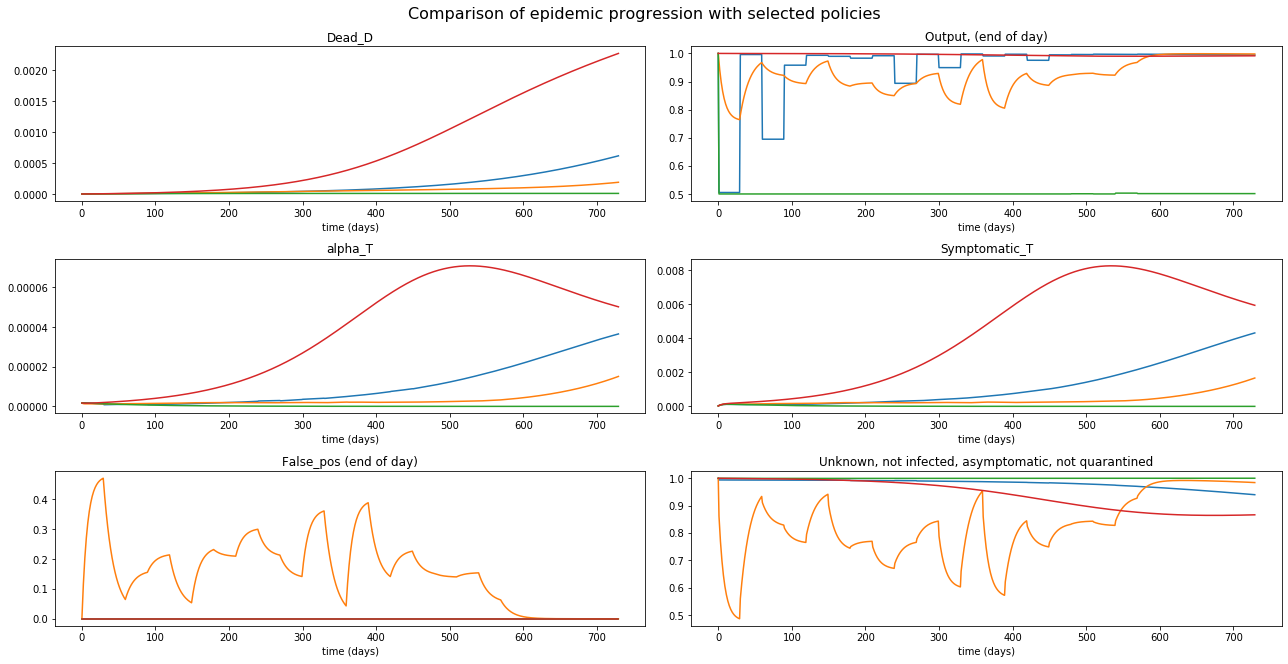

In [74]:
# comparison plot for selected policies
simulators = {medoids_df.loc[index, 'run']: epidemic_simulators[index] for index in compare_indices}
simulators['base_case_no_control'] = epidemic_simulators['base_case_no_control']
results = {medoids_df.loc[index, 'run']: res[index] for index in compare_indices}
results['base_case_no_control'] = res['base_case_no_control']
#policies={medoids_df.loc[index, 'run']: policies[index] for index in compare_indices}

fig = epidemic_progression_plot([7, 11, 22, 26, 4, 16], simulators, results)
fig.suptitle("Comparison of epidemic progression with selected policies", fontsize=16, y=1.02)
fig.tight_layout()
fig.savefig("figures/progression_comparison.png", dpi=150)

## Sparklines for process

/Users/ljneuvon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:151: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



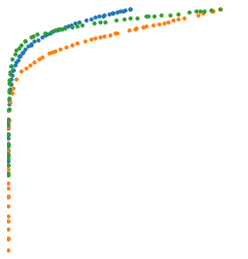

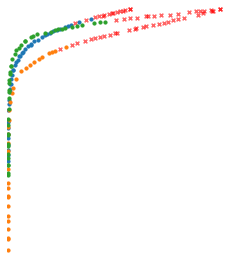

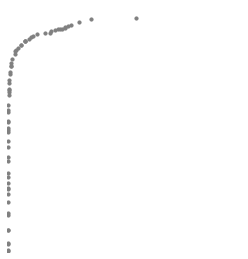

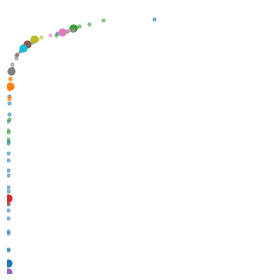

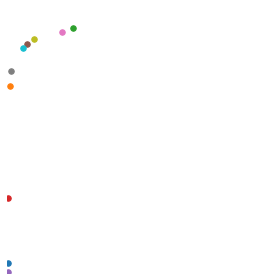

In [90]:
# SPARKLINE FIGURES!

sparkline_runs = ['combo_base_case',
            'base_case_lockdown_opt',
            'romer_tc_50000000_sens_spec_085',
                 # 'romer_tc_50000000'
            ]

fig = plt.figure(figsize=(4,4))

plot_run_dict = { run: runs[run] for run in sparkline_runs }
obj_dict = { run: full_results[run][['Deaths', 'Economic impact']] for run in plot_runs }

ax1 = plt.subplot()
for run in sparkline_runs:
    ax1.scatter(obj_dict[run].Deaths, -obj_dict[run]['Economic impact'], label=run_labels[run], s=10)

#box = ax1.get_position()
#ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
#ax1.legend(loc = 'center left', bbox_to_anchor=(0.03,0.3))

#plt.xlabel('Deaths, x1000')
#plt.ylabel('Integrated Economic Output')
plt.ylim([0.5, 1.0])
plt.xlim([0, 250])
fig.tight_layout()

#remove all the axes
for k,v in ax1.spines.items():
    v.set_visible(False)
ax1.set_xticks([])
ax1.set_yticks([])

fig.savefig("figures/pruning_spark1.png", dpi=150)

fig = plt.figure(figsize=(4,4))



ax2 = plt.subplot()
for run in sparkline_runs:
    ax2.scatter(low_risk_by_run[run].Deaths, -low_risk_by_run[run]['Economic impact'], label=run_labels[run], s=10)
    ax2.scatter(high_risk_by_run[run].Deaths, -high_risk_by_run[run]['Economic impact'], label=run_labels[run], marker="x", color='red', s=14, alpha=0.6)

#box = ax2.get_position()
#ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])
#ax2.legend(loc = 'center left', bbox_to_anchor=(0.03,0.3))

#plt.xlabel('Deaths, x1000')
#plt.ylabel('Integrated Economic Output')
plt.ylim([0.5, 1.0])
plt.xlim([0, 250])
fig.tight_layout()

#remove all the axes
for k,v in ax2.spines.items():
    v.set_visible(False)
ax2.set_xticks([])
ax2.set_yticks([])

fig.savefig("figures/pruning_spark2.png", dpi=150)

fig = plt.figure(figsize=(4,4))

ax3 = plt.subplot()
ax3.scatter(non_dom_low_risk.Deaths, -non_dom_low_risk['Economic impact'], c='gray', label='Non-dominated, risk<10%', s=10
           )
#plt.xlabel('Deaths, x1000')
#plt.ylabel('Integrated Economic Output')
plt.ylim([0.5, 1.0])
plt.xlim([0, 250])

#box = ax.get_position()
#ax3.set_position([box.x0, box.y0, box.width * 0.8, box.height])
#ax3.legend(loc = 'center left', bbox_to_anchor=(0.03,0.3))
fig.tight_layout()

#remove all the axes
for k,v in ax3.spines.items():
    v.set_visible(False)
ax3.set_xticks([])
ax3.set_yticks([])

fig.savefig("figures/pruning_spark3.png", dpi=150)

fig = plt.figure(figsize=(4,4))

ax4 = plt.subplot()
run_df = non_dom_low_risk
color=iter(cm.tab10(np.linspace(0,1,10)))
for i in range(0,n_clusters):
    c=next(color)
    ax4.scatter(run_df[run_df['cluster']==i].Deaths, 
                -run_df[run_df['cluster']==i]["Economic impact"], 
                label="Cluster "+str(i),
               alpha=0.5, 
               s=10, color=c)
    ax4.scatter(medoids_df.iloc[i,:].Deaths, 
                -medoids_df.iloc[i,:]["Economic impact"],
               s=50, color=c)
plt.ylim([0.5, 1.0]) 
plt.xlim([0, 250])

#plt.xlabel('Deaths, x1000')
#plt.ylabel('Integrated Economic Output')

#box = ax4.get_position()
#ax4.set_position([box.x0, box.y0, box.width * 0.8, box.height])
#ax4.legend(loc = 'center left', bbox_to_anchor=(0.03, 0.3))


#remove all the axes
for k,v in ax4.spines.items():
    v.set_visible(False)
ax4.set_xticks([])
ax4.set_yticks([])

fig.tight_layout()

fig.savefig("figures/pruning_spark4.png", dpi=150)

fig = plt.figure(figsize=(4,4))

ax5 = plt.subplot()
color=iter(cm.tab10(np.linspace(0,1,10)))
#ax.scatter(run_df.Deaths, -run_df['Economic impact'], s=10, c='gray')
medoids_sorted_by_cluster = medoids_df.sort_values('cluster')
for i in medoids_sorted_by_cluster.index:
   
    c=next(color)
    ax5.scatter(medoids_df.loc[i, 'Deaths'], -medoids_df.loc[i, 'Economic impact'], s=30, color=c, label=run_labels[medoids_df.loc[i, 'run']])
    #ax5.annotate(medoids_df['max ICUOL P'][i], (medoids_df.loc[i, 'Deaths']+1, -medoids_df.loc[i, 'Economic impact']-0.015))


#plt.xlabel('Deaths, x1000')
#plt.ylabel('Integrated Economic Output')
plt.ylim([0.5, 1.0])
plt.xlim([0, 250])

#box = ax5.get_position()
#ax5.set_position([box.x0, box.y0, box.width * 0.8, box.height])
#ax5.legend(loc = 'center left', bbox_to_anchor=(0.03,0.3))

#remove all the axes
for k,v in ax5.spines.items():
    v.set_visible(False)
ax5.set_xticks([])
ax5.set_yticks([])

fig.tight_layout()
fig.show()
fig.savefig("figures/pruning_spark5.png", dpi=150)

## Other policies

run:  romer_tc_50000000_sens_spec_085
pol:  {1: 0.018058456448365644, 30: 0.007588467331490991, 60: 0.01340937092572984, 90: 0.005070797480993082, 120: 0.011970640137360494, 150: 0.009670991359611652, 180: 0.010216215688546762, 210: 0.011674514458518808, 240: 0.0032550121057143013, 270: 0.00022217289962720655, 300: 0.022732171274956983, 330: 0.001478427604036872, 360: 0.004682581563114707, 390: 0.00971064459834357, 420: 0.0016353000122694321, 450: 0.006501921315301164, 480: 0.006429178178540706, 510: 0.005321896360566087, 540: 0.0002512207942748151, 570: 5.900742873204896e-07}
simu:  {'tau_paramA': 0.0, 'test_sens': 0.85, 'test_spec': 0.85, 'tau_TT': 0.0, 'ksi_U': 0.0, 'ksi_P': 0.05071910291597881, 'ksi_N': 0.0, 'ksi_R': 0.0, 'r_U': 0.006831096210018872, 'r_P': 0.0, 'r_AP': 0.0, 'r_N': 0.05000259097827642, 'r_R': 0.05000259097827642, 'd_start_exp': 0.0, 'experiment': 'baseline_vaccine_tag'}
medoid results: Deaths:  25.513416196676765  | Output:  0.9382146889730612


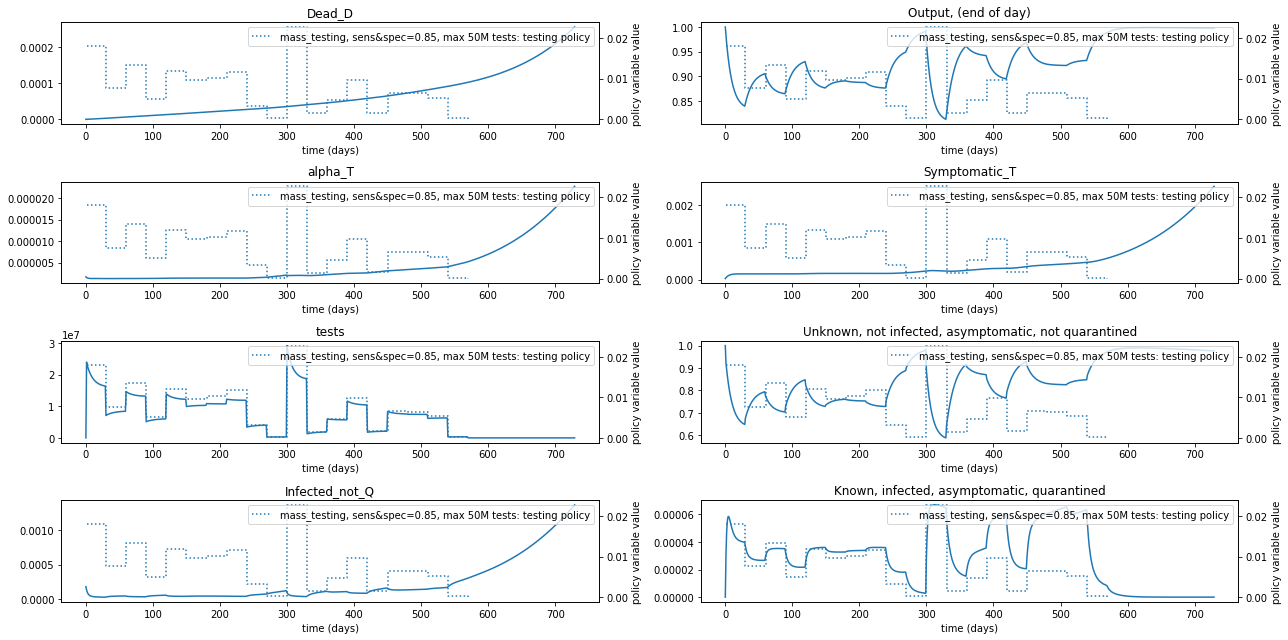

In [80]:
index = 262
run = medoids_df.loc[index, 'run']
print("run: ", run)
print("pol: ", policies[index].testing_policy)
print("simu: ",  epidemic_simulators[index][1])
print("medoid results: Deaths: ", medoids_df.loc[index, 'Deaths'], " | Output: ", -medoids_df.loc[index, 'Economic impact']  )
fig = epidemic_progression_plot([7, 11, 22, 26, 15, 16, 9, 21], {run: epidemic_simulators[index]}, {run: res[index]}, policies={run: policies[index]})
fig.tight_layout()